In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain # need this for plots below

%matplotlib inline

# load the dataframe
esg = pd.read_csv('../data/esg_metadata.csv')

Show the columns of interest

In [58]:
# create some arrays of key display and logic fields
expl_a_g = list(map(lambda x: 'expl_'+x, list('abcdefg')))
expl_c_g = list(map(lambda x: 'expl_'+x, list('cdefg')))
explans = ['no_gap']+expl_a_g
core_fields = ['sector','cetsid','input_name']+explans

# look just at the no_gap indicators: these should not have any expl variables set
esg[esg['no_gap']==1][core_fields]

,sector,cetsid,input_name,no_gap,expl_a,expl_b,expl_c,expl_d,expl_e,expl_f,expl_g
2,ENV,AG.LND.TOTL.K2,Land area (sq. km),1,0,0,0,0,0,0,0
5,GOV,CC.EST,Control of Corruption: Estimate,1,0,0,1,0,0,0,0
26,ENV,EN.CLC.CDDY.XD,Cooling Degree Days,1,0,0,0,0,0,0,0
28,ENV,EN.CLC.HEAT.XD,Health index 35,1,0,0,0,0,0,0,0
30,ENV,EN.CLC.PRCP.XD,Maximum 5-day Rainfall (25-yr RL),1,0,0,0,0,0,0,0
31,ENV,EN.CLC.SPEI.XD,Mean drought index (SPEI),1,0,0,0,0,0,0,0
32,ENV,EN.MAM.THRD.NO,"Mammal species, threatened",1,0,0,0,0,0,0,0
33,ENV,EN.POP.DNST,Population density (people per sq. km of land ...,1,0,0,0,0,0,0,0
40,ENV,ER.PTD.TOTL.ZS,Terrestrial and marine protected areas (% of t...,1,0,0,0,0,0,0,0
45,GOV,GE.EST,Government Effectiveness: Estimate,1,0,0,1,0,0,0,0


Indicators that have no gaps should also have no explanations or our analysis will be off. So clearly we need to fix some of our logic.

In [59]:
# 'no_gap' fields should not have any expl variables set
esg.loc[esg['no_gap']==1,expl_a_g] = 0
# test
esg[esg['no_gap']==1][core_fields]

,sector,cetsid,input_name,no_gap,expl_a,expl_b,expl_c,expl_d,expl_e,expl_f,expl_g
2,ENV,AG.LND.TOTL.K2,Land area (sq. km),1,0,0,0,0,0,0,0
5,GOV,CC.EST,Control of Corruption: Estimate,1,0,0,0,0,0,0,0
26,ENV,EN.CLC.CDDY.XD,Cooling Degree Days,1,0,0,0,0,0,0,0
28,ENV,EN.CLC.HEAT.XD,Health index 35,1,0,0,0,0,0,0,0
30,ENV,EN.CLC.PRCP.XD,Maximum 5-day Rainfall (25-yr RL),1,0,0,0,0,0,0,0
31,ENV,EN.CLC.SPEI.XD,Mean drought index (SPEI),1,0,0,0,0,0,0,0
32,ENV,EN.MAM.THRD.NO,"Mammal species, threatened",1,0,0,0,0,0,0,0
33,ENV,EN.POP.DNST,Population density (people per sq. km of land ...,1,0,0,0,0,0,0,0
40,ENV,ER.PTD.TOTL.ZS,Terrestrial and marine protected areas (% of t...,1,0,0,0,0,0,0,0
45,GOV,GE.EST,Government Effectiveness: Estimate,1,0,0,0,0,0,0,0


In [60]:
# expl_a and expl_b should not have any other explanatory variables set
esg.loc[(esg['expl_a']==1) | (esg['expl_b']==1), expl_c_g] = 0

# test
esg[(esg['expl_a']==1) | (esg['expl_b']==1)][core_fields]

,sector,cetsid,input_name,no_gap,expl_a,expl_b,expl_c,expl_d,expl_e,expl_f,expl_g
18,ENV,EN.ATM.CO2E.KT,CO2 emissions (kt),0,0,1,0,0,0,0,0
19,ENV,EN.ATM.CO2E.PC,CO2 emissions (metric tons per capita),0,0,1,0,0,0,0,0
24,ENV,EN.ATM.PM10.MC.M3,"PM10, country level (micrograms per cubic meter)",0,1,0,0,0,0,0,0
27,ENV,EN.CLC.GHGR.MT.CE,GHG net emissions/removals by LUCF (Mt of CO2 ...,0,0,1,0,0,0,0,0
29,ENV,EN.CLC.MDAT.ZS,"Droughts, floods, extreme temperatures (% of p...",0,0,1,0,0,0,0,0
34,ENV,EN.POP.EL5M.ZS,Population living in areas where elevation is ...,0,0,1,0,0,0,0,0
36,ENV,ER.BDV.TOTL.XQ,GEF benefits index for biodiversity (0 = no bi...,0,1,0,0,0,0,0,0
37,ENV,ER.H2O.FWTL.ZS,"Annual freshwater withdrawals, total (% of int...",0,0,1,0,0,0,0,0
38,ENV,ER.H2O.INTR.K3,"Renewable internal freshwater resources, total...",0,0,1,0,0,0,0,0
39,ENV,ER.H2O.INTR.PC,Renewable internal freshwater resources per ca...,0,0,1,0,0,0,0,0


In [61]:
# Summarize by type and sector
esg.pivot_table(index='source_type',columns='sector', aggfunc='count',values='cetsid',margins=True).reindex(['WBG', 'UN', 'OTHER', 'All'],axis=0).reindex(['ENV', 'SOC', 'GOV','All'], axis=1)

sector,ENV,SOC,GOV,All
source_type,,,,
WBG,10,12,14,36
UN,9,49,8,66
OTHER,25,5,2,32
All,44,66,24,134


In [62]:
# New column that divides sources into WBG and all other external
esg['domain'] = np.where(esg['source_type']!='WBG','EXTERNAL',esg['source_type'])

# Show explanations, disaggregated by domain
esg.groupby(['domain']).sum()[explans]

,no_gap,expl_a,expl_b,expl_c,expl_d,expl_e,expl_f,expl_g
domain,,,,,,,,
EXTERNAL,8,10,8,58,5,8,19,10
WBG,6,5,3,14,0,0,13,2


In [63]:
# limit to the WBG dataset
esg[esg['wbgv1']==1].groupby(['domain']).sum()[explans]

,no_gap,expl_a,expl_b,expl_c,expl_d,expl_e,expl_f,expl_g
domain,,,,,,,,
EXTERNAL,7,0,4,32,3,6,11,5
WBG,6,0,0,8,0,0,7,1


So to me, the big takeaway here is that the big "gaps" are around methodology and household surveys, but we would be very dependent on external sources to make changes, particularly for the WBG dataset

In [231]:
# Disaggregate by sector as well
esg.groupby(['domain', 'sector']).sum()[explans]

no_gap  expl_a  expl_b  expl_c  expl_d  expl_e  expl_f  \
domain   sector                                                           
EXTERNAL ENV          8       1       8      17       4       8       0   
         GOV          0       3       0       6       0       0       1   
         SOC          0       6       0      35       1       0      18   
WBG      ENV          0       2       3       5       0       0       0   
         GOV          6       0       0       1       0       0       7   
         SOC          0       3       0       8       0       0       6   

                 expl_g  
domain   sector          
EXTERNAL ENV          3  
         GOV          3  
         SOC          4  
WBG      ENV          2  
         GOV          0  
         SOC          0

In [230]:
# just the WBG dataset
esg[esg['wbgv1']==1].groupby(['domain', 'sector']).sum()[explans]

no_gap  expl_a  expl_b  expl_c  expl_d  expl_e  expl_f  \
domain   sector                                                           
EXTERNAL ENV          7       0       4      13       2       6       0   
         GOV          0       0       0       3       0       0       1   
         SOC          0       0       0      16       1       0      10   
WBG      ENV          0       0       0       2       0       0       0   
         GOV          6       0       0       0       0       0       2   
         SOC          0       0       0       6       0       0       5   

                 expl_g  
domain   sector          
EXTERNAL ENV          2  
         GOV          2  
         SOC          1  
WBG      ENV          1  
         GOV          0  
         SOC          0

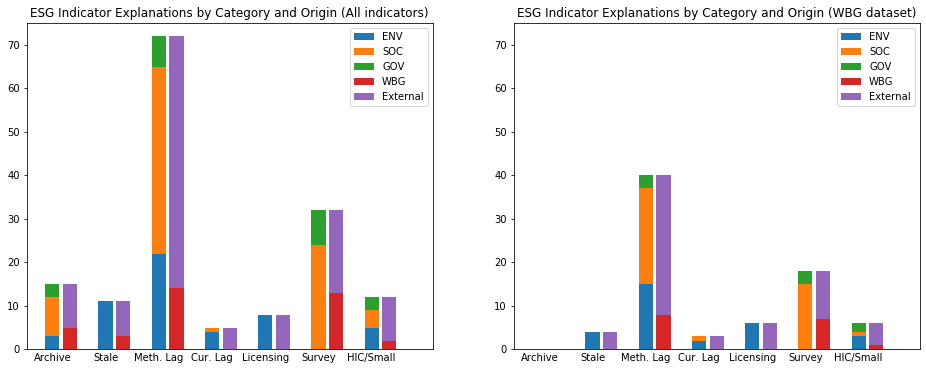

In [222]:
# plots
def every_other(n,odd=True,fill=0):
    z = list(chain.from_iterable(list(map(lambda x: [fill,x,fill], n))))
    if odd:
        z = z[1:]
        z.append(fill)
    
    return z

def plot_esg(limit):
    esg2 = esg[(esg['wbgv1']==1) | (not limit)]
    sector_data = esg2.groupby(['sector']).sum()[expl_a_g]
    origin_data = esg2.groupby(['domain']).sum()[expl_a_g]
    sx = range(0,len(sector_data.columns)*3)

    pEnv = plt.bar(sx, every_other(sector_data.loc['ENV']))
    pSoc = plt.bar(sx, every_other(sector_data.loc['SOC']),bottom=every_other(sector_data.loc['ENV']))
    pGov = plt.bar(sx, every_other(sector_data.loc['GOV']),bottom=every_other(sector_data.loc['ENV']+sector_data.loc['SOC']))
    pWbg = plt.bar(sx, every_other(origin_data.loc['WBG'],False))
    pExt = plt.bar(sx, every_other(origin_data.loc['EXTERNAL'],False),bottom=every_other(origin_data.loc['WBG'],False))
    plt.xticks(sx, labels=every_other(['Archive', 'Stale', 'Meth. Lag', 'Cur. Lag', 'Licensing', 'Survey', 'HIC/Small'],fill=None))
    plt.tick_params(axis='x', length=0)
    plt.ylim(0, 75)

    plt.legend((pEnv, pSoc, pGov,pWbg, pExt), ('ENV', 'SOC', 'GOV', 'WBG', 'External'))
    plt.title('ESG Indicator Explanations by Category and Origin ({})'.format('WBG dataset' if limit else 'All indicators'))

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_esg(False)
plt.subplot(1, 2, 2)
plot_esg(True)